In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.optimize import curve_fit


## Creating Bak-Sneppen model

Steps:
Inititalize percolation grid
Start time loop
For every time iteration:
    Calculate probabilities that neighbours change

In [24]:
class SimulationGrid:
    def __init__(self, size, lambda_rate = 0.9, low=0.0, high=1.0):
        self.size = size
        self.threshold = []
        self.low = low
        self.high = high
        self.fitness_max = -1
        self.minima = []
        self.history = []
        self.num_iterations = 0
        self.avalanche_length = []
        self.current = self.initialize_grid()
        self.lambda_rate = lambda_rate  # Adjust as needed
        # Schedule the first information event
        self.time_for_next_info = np.random.exponential(scale=1/self.lambda_rate)
        
    def restart(self):
        self.current = self.history[0]
        self.history = []
        self.minima = []
        self.threshold_fitness = []
        self.fitness_max = -1

    def initialize_grid(self):
        np.random.seed(123)
        return np.array([[np.random.uniform(self.low, self.high) for _ in range(self.size)] for _ in range(self.size)])

    def visualize(self):
        cmap = 'viridis'
        plt.imshow(self.current, cmap=cmap, interpolation='nearest')
        plt.title('2D Grid Initialized with Uniform Distribution')
        plt.colorbar()
        plt.show()

    def draw_value(self):
#         return np.random.normal(loc=self.mean, scale=self.std, size=(self.size, self.size))
        return np.random.uniform(self.low, self.high)

    def avalanche_frequencies(self):  
        freq = {}
        for value in self.avalanche_length:
            if value in freq:
                freq[value] += 1
            else:
                freq[value] = 1
                
        lst = np.array([[key,freq[key]] for key in freq])
        sorted_indices = np.argsort(lst[:, 0])
        # Use the sorted indices to sort the array
        sorted_frequencies = lst[sorted_indices]
        
        return sorted_frequencies
    
    def introduce_new_information(self, current_time, num_clusters, fitness_value, lambda_rate):
        """
        Introduces a cluster of new information based on an exponential distribution to 
        determine the timing of events.
        
        :param current_time: The current time step in the simulation.
        :param fitness_value: The fitness value to assign to the new information clusters.
        """
        if current_time >= self.time_for_next_info:
            # Determine the number of clusters to introduce (can be based on Poisson or another approach)
            for _ in range(num_clusters):
                # Select a random site for the new information
                site = np.random.randint(0, self.size)
                # Update self.current instead of self.grid
                i, j = np.unravel_index(site, self.current.shape)
                self.current[i, j] = fitness_value

            # Schedule the next information event
            self.time_for_next_info += np.random.exponential(scale=1/self.lambda_rate)
            
    def adjust_neighbor_fitness(self, i, j, bias=0):
        """
        Adjusts the fitness of a neighbor based on its original value.
        The adjustment weight is randomly chosen from U(0,1) and the direction (+ or -)
        is determined by a Bernoulli trial.
        """
        original_value = self.current[i, j]
        weight = np.random.uniform(0, 1)  # Weight is randomly chosen from U(0,1)
        k = bias
        change_direction = 1 if np.random.rand() < (0.5-k) else -1 # Direction is determined by a Bernoulli trial
#         change_direction = -1
        adjustment = original_value * weight * change_direction
        new_value = original_value + adjustment

        # Ensure the new value is within the bounds -> [0,1]
        return max(min(new_value, self.high), self.low)

    def run_iterations(self, iterations, bias =0 ,num_clusters = 0, lambda_rate = 0.9,event_fitness=0.1, save=False):
        self.num_iterations= iterations
        avalanche_size = 0
        fitness_max = 0
        for t in range(iterations):
            
            # Introduce new information if the time has come
            if num_clusters > 0:
                self.introduce_new_information(t, num_clusters, event_fitness, lambda_rate)
            
            #Choosing to save values 
            if save:
                self.history.append(self.current.copy())  # Use copy to save the state, not a reference

            # Getting min index and saving minimum value
            min_index = np.unravel_index(self.current.argmin(), self.current.shape)
            minimum = self.current[min_index[0], min_index[1]]
            self.minima.append(minimum)
            
            
            #Updating fitness threshold and saving
            avalanche_size += 1
            if fitness_max < minimum:
                    self.avalanche_length.append(avalanche_size)
                    self.threshold.append((t,minimum))
                    fitness_max = minimum
                    avalanche_size = 0 
    

            # I could make this part more efficient but too lazy for now
            neighbors = [
                (min_index[0] - 1, min_index[1]),  # Above
                (min_index[0] + 1, min_index[1]),  # Below
                (min_index[0], min_index[1] - 1),  # Left
                (min_index[0], min_index[1] + 1)   # Right
            ]

            # Keeping only 'useful' indexes
            indices = [(i, j) for i, j in neighbors if 0 <= i < self.current.shape[0] and 0 <= j < self.current.shape[1]]

#             Updating neighbors and worst value
#             for index in indices:
#                 i, j = index
#                 self.current[i, j] = self.draw_value()

#             self.current[min_index[0], min_index[1]] = self.draw_value()
            
            for i, j in indices:
#                 self.current[i, j] = self.draw_value()
                self.current[i, j] = self.adjust_neighbor_fitness(i, j, bias)
                
            self.current[min_index[0], min_index[1]] = self.draw_value()
        
        self.threshold.append((t,fitness_max))
        self.threshold = np.array(self.threshold)

# An avalanche is a cascade of fitness changes below the threshold (i.e. all the blinking dots below the
# line), although this behavior also results in random fitness changes above the line. An avalanche lasts
# as long as any activity remains below the threshold, and the length of the avalanche is the number of
# mutations below the threshold.

## Running and visualizing grid

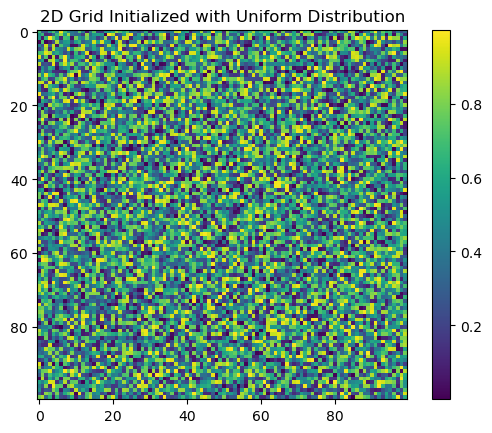

0.08310354419654561
0.050945325332520566


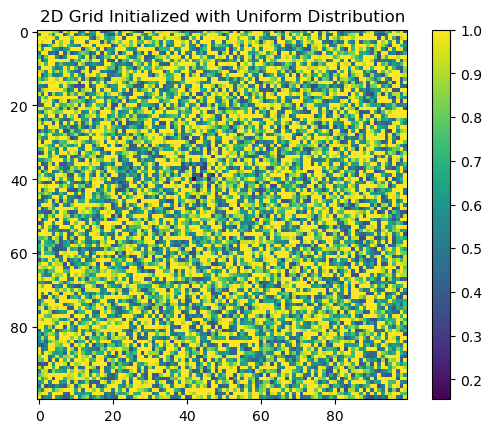

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,  99., 111., 109., 102., 120., 120.,  98.,  96., 108.,  89.,
         94., 102., 119.,  97., 101., 104.,  91.,  85., 105.,  98., 102.,
        110.,  97.,  83., 100., 103.,  98.,  90.,  90.,  91.,  97.,  90.,
         66., 103.,  76.,  86.,  91.,  69.,  87.,  79.,  92.,  72.,  75.,
         79.,  81.,  91.,  99.,  93.,  87.,  86.,  85.,  88.,  57.,  71.,
         86.,  66.,  71.,  76.,  84.,  74.,  71.,  86.,  74.,  77.,  82.,
         82.,  61.,  69.,  61.,  75.,  46.,  62.,  54.,  50.,  79.,  65.,
         53.]),
 array([0.15445216, 0.16290674, 0.17136132, 0.1798159 , 0.18827048,
        0.19672506, 0.20517964, 0.21363423, 0.22208881, 0.23054339,
        0.23899797, 0.24745255, 0.25590713, 0.26436171, 0.27281629,
        0.28127087, 0.28972546, 0.29818004, 0.30663462, 0.3150892 ,
        0.32354378, 0.33199836, 0.34045294, 0.

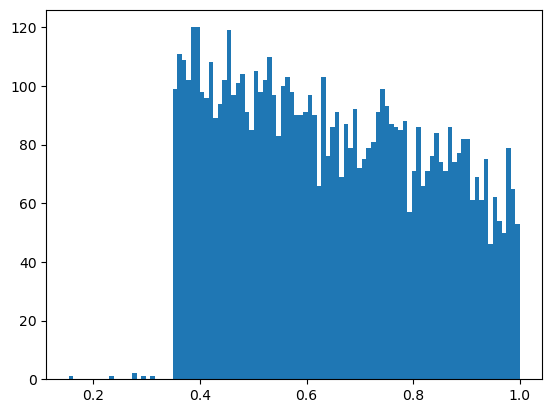

In [25]:
grid = SimulationGrid(100)
grid.visualize()
print(np.var(grid.current))
plt.show()
#  run_iterations(self, iterations, num_clusters = 0, lambda_rate = 0.9,event_fitness=0.1, save=False)

grid.run_iterations(100000, bias = 0, num_clusters= 0, save=False)
print(np.var(grid.current))
grid.visualize()
plt.show()


data = grid.current.flatten()
plt.hist(data[data<1], bins= 100)


# plt.hist(grid.minima, bins = 100)
# plt.show()

# plt.scatter([k for k in range(len(grid.minima))] , grid.minima)

## Plotting variance against order thing (phase transition for rule 2 )

#### Calculating Variances

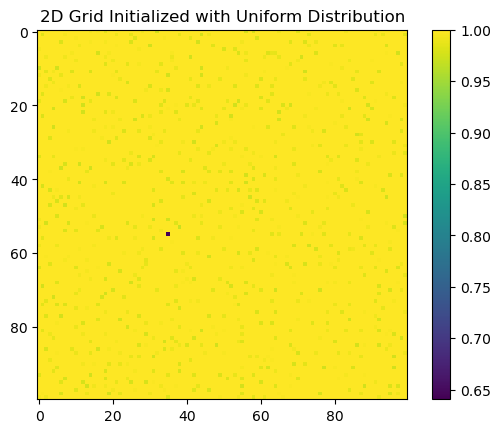

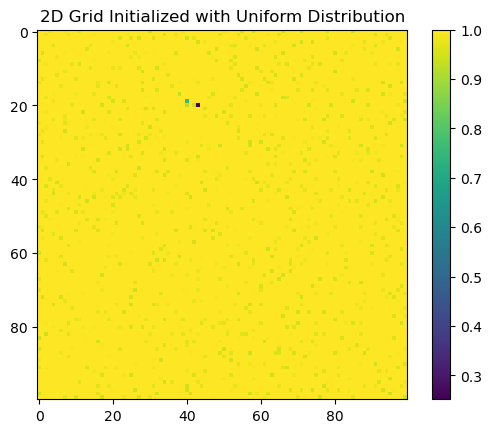

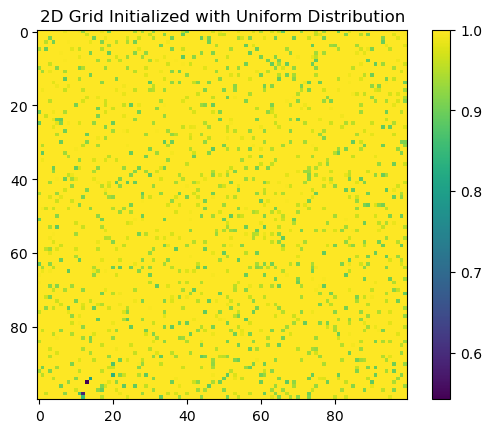

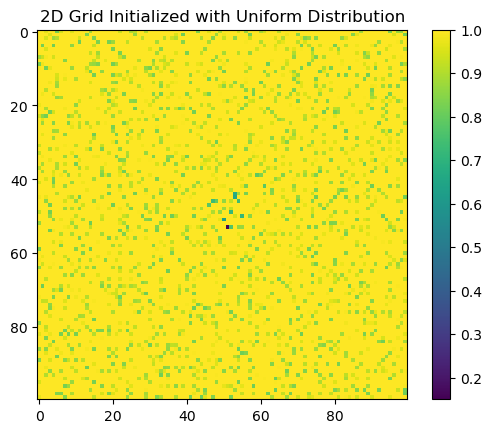

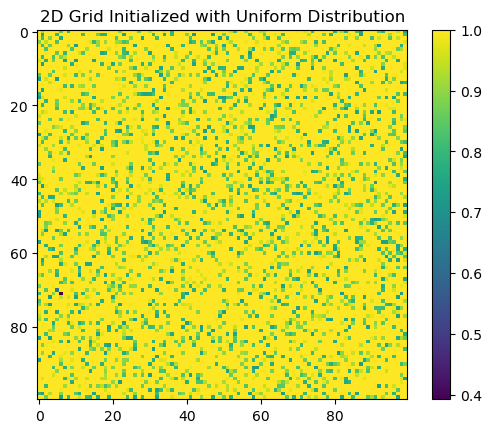

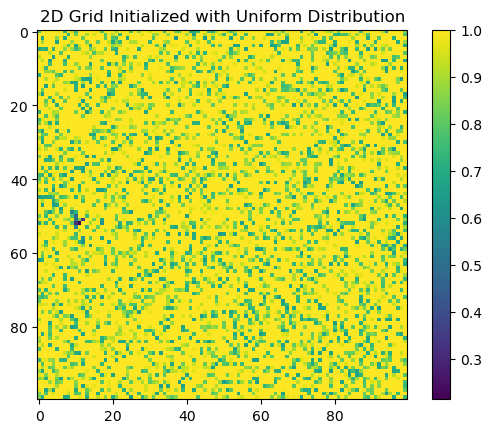

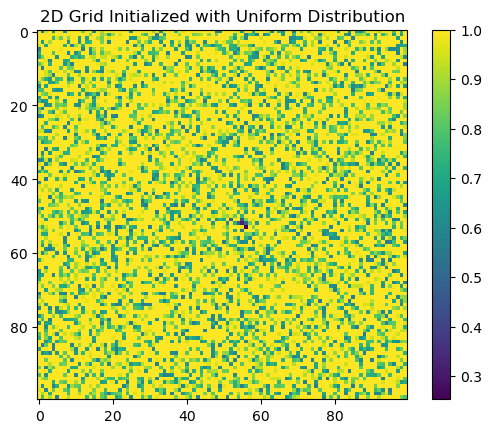

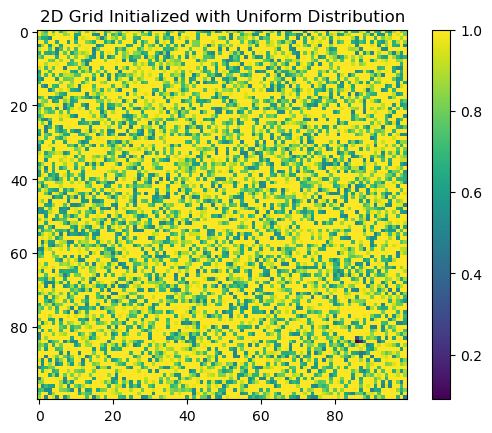

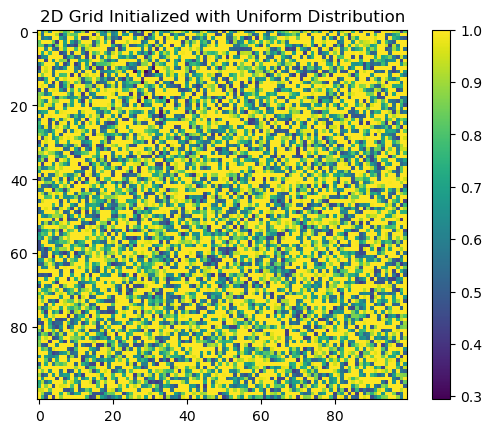

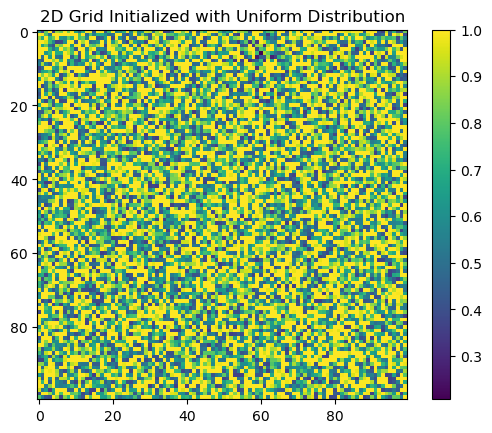

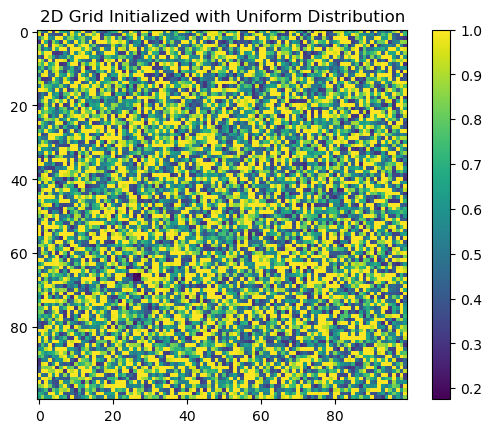

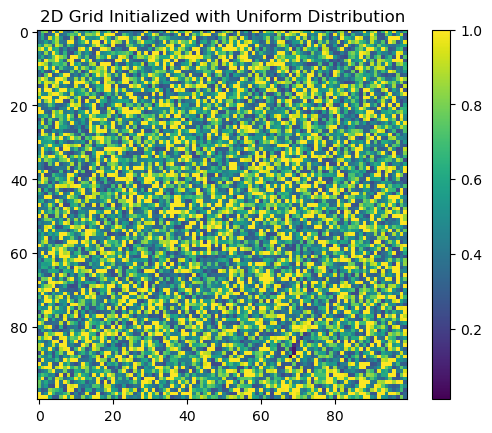

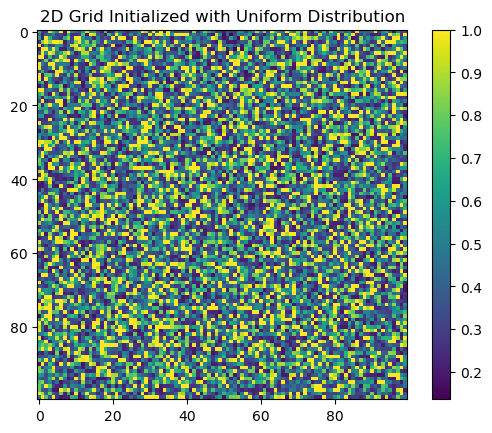

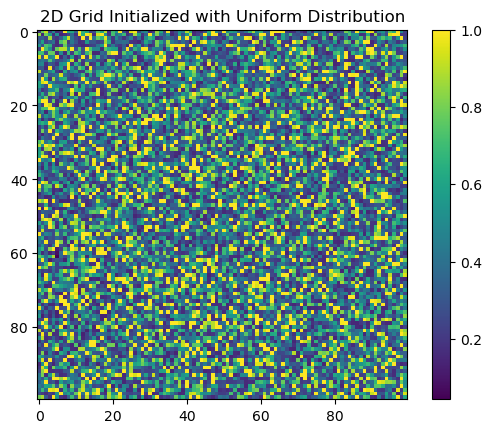

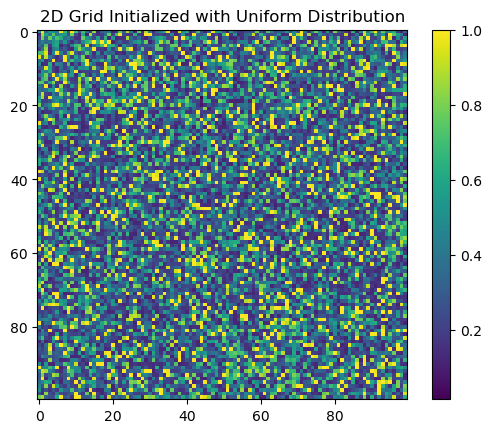

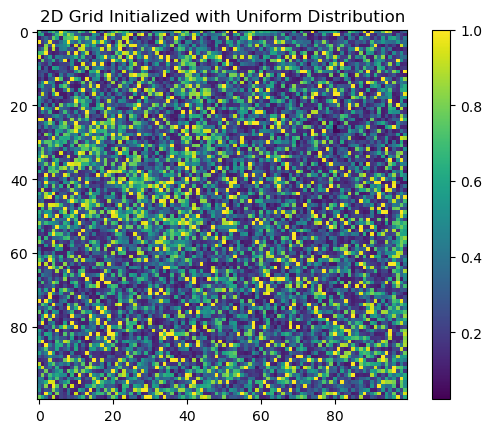

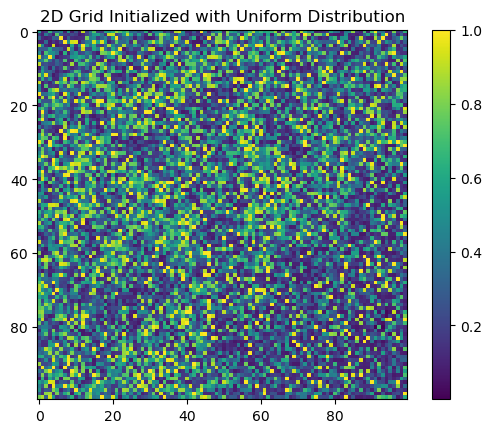

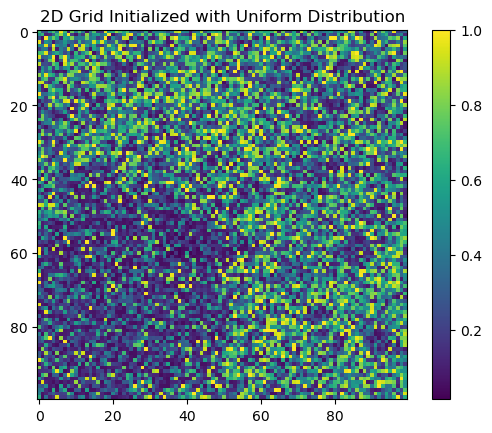

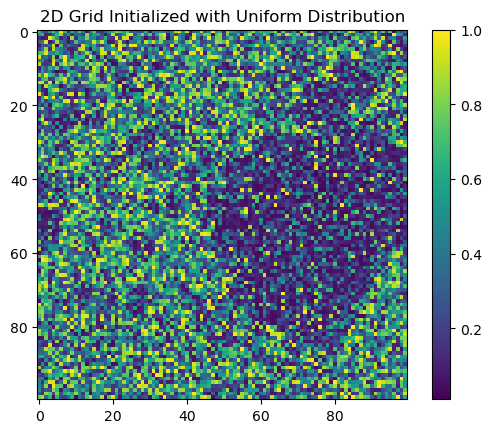

In [37]:
bias_list = np.arange(-0.45, 0.45+0.05,0.05)
grids  = [SimulationGrid(100) for k in range(len(bias_list))]
variance_list = []
means_list = []

for indx,k in enumerate(bias_list):
    grid = grids[indx]
    grid.run_iterations(100000, bias = k, num_clusters= 0, save=False)
    grid.visualize()
    plt.show()
    mean = np.mean(grid.current) 
    means_list.append(mean)
    variance = np.var(grid.current)
    variance_list.append(variance)


[0.07751540599735735, 0.07794180241711775, 0.07848968082634124, 0.07963706127693332, 0.07947630960133252, 0.0801507727053065, 0.08010024886721945, 0.08078896819785707, 0.08169167276344633, 0.08163407464074954]
[0.3        0.31666667 0.33333333 0.35       0.36666667 0.38333333
 0.4        0.41666667 0.43333333 0.45      ]


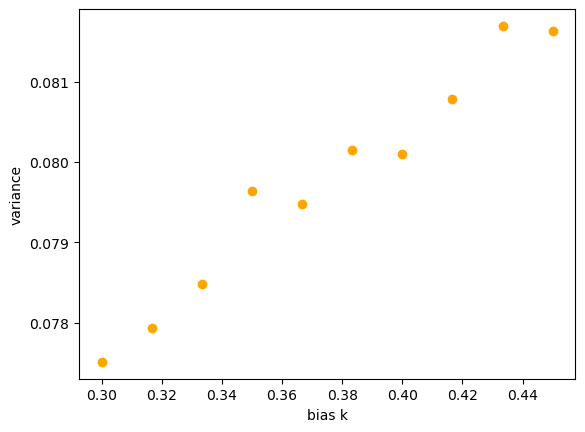

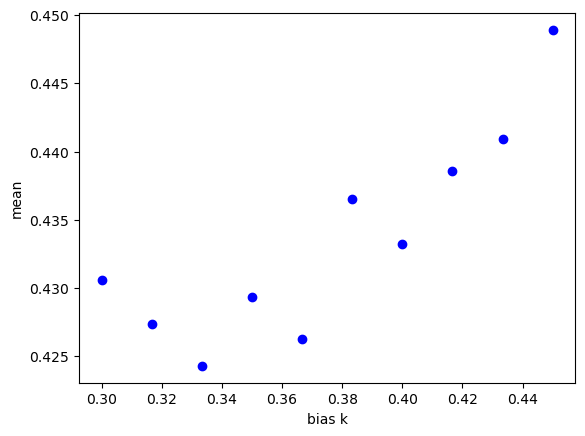

In [17]:
print(variance_list)
print(bias_list)

plt.scatter(bias_list, variance_list, color= 'orange')
plt.xlabel('bias k')
plt.ylabel('variance')
plt.show()

plt.scatter(bias_list, means_list, color = 'blue')
plt.xlabel('bias k')
plt.ylabel('mean')
plt.show()

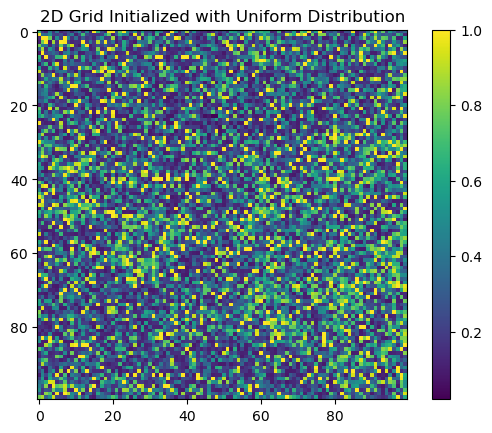

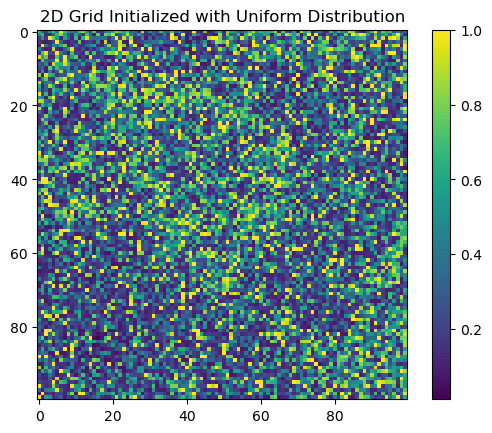

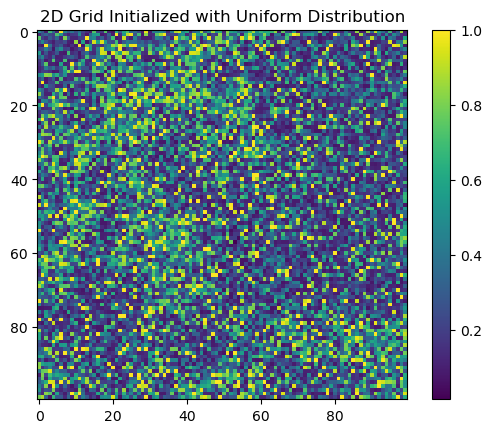

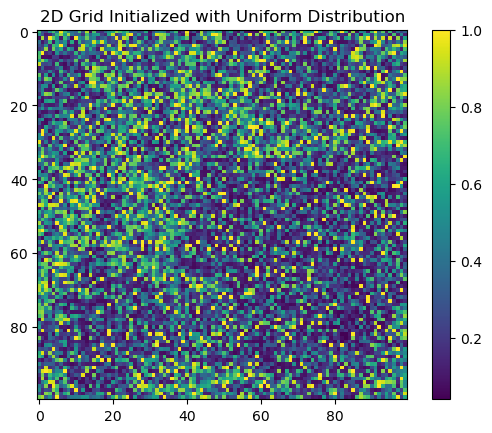

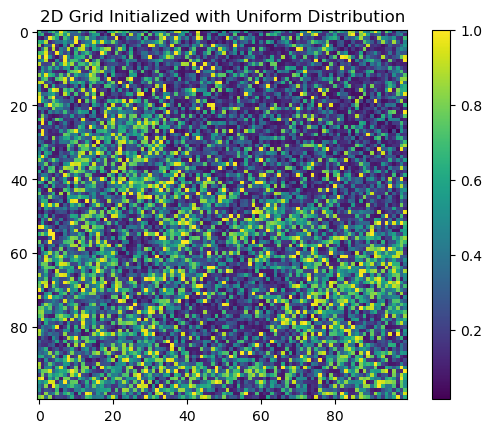

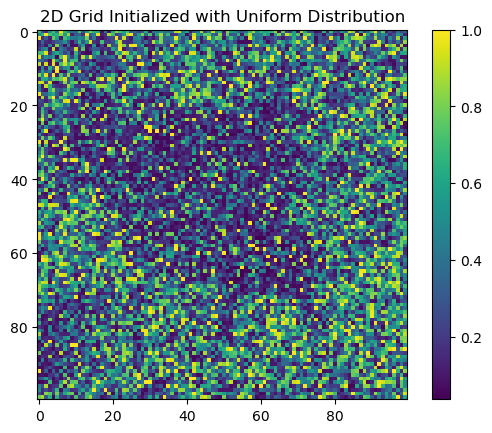

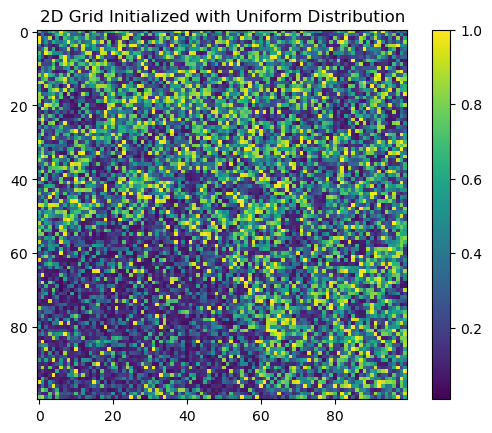

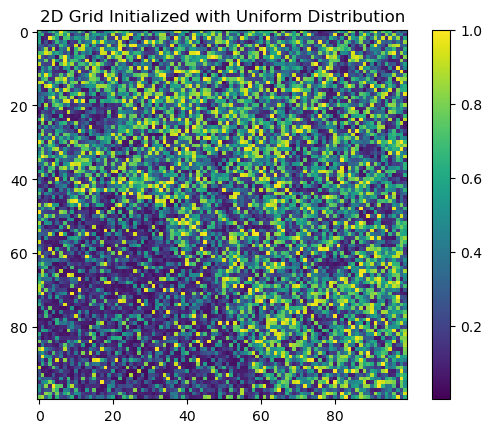

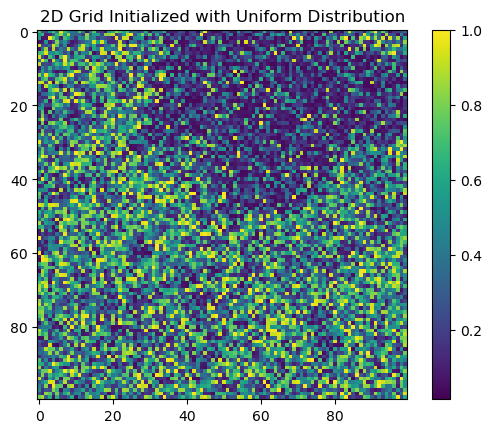

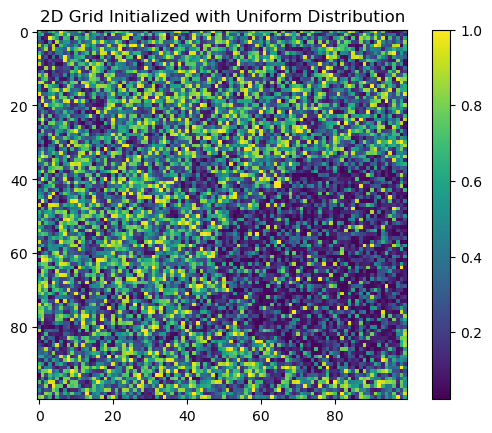

In [42]:
bias_list = np.linspace(0.3, 0.45, 10)
grids  = [SimulationGrid(100) for k in range(len(bias_list))]
variance_list = []
means_list = []

for indx,k in enumerate(bias_list):
    grid = grids[indx]
    grid.run_iterations(100000, bias = k, num_clusters= 0, save=False)
    grid.visualize()
    plt.show()
    mean = np.mean(grid.current) 
    means_list.append(mean)
    variance = np.var(grid.current)
    variance_list.append(variance)

### Studying variance 

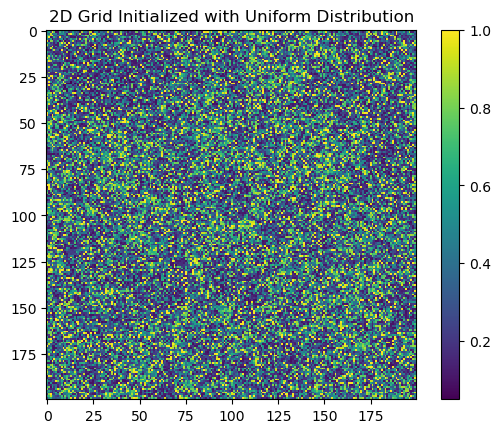

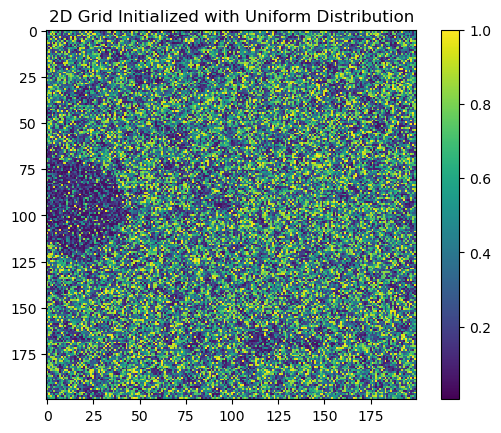

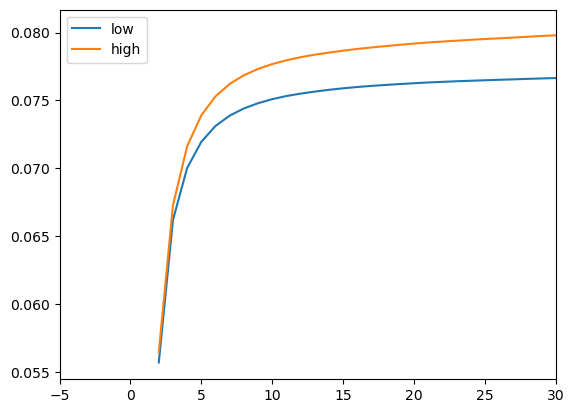

In [30]:
def calculate_variance_with_window(array, window_size):
    variances = []
    rows, cols = array.shape

    for i in range(rows - window_size + 1):
        for j in range(cols - window_size + 1):
            window = array[i:i+window_size, j:j+window_size]
            variance = np.var(window)
            variances.append(variance)

    return variances



low_bias, high_bias = grids[0], grids[-1]

low_bias.visualize()
plt.show()
high_bias.visualize()
plt.show()

window_sizes = np.arange(2, 50+1, 1)

variances1 = [calculate_variance_with_window(low_bias.current, size) for size in window_sizes]
variances2 = [calculate_variance_with_window(high_bias.current, size) for size in window_sizes]

plt.plot(window_sizes, [np.mean(variances) for variances in variances1], label = 'low')
plt.plot(window_sizes, [np.mean(variances) for variances in variances2], label = 'high')
plt.xlim(-5,30)
plt.legend()


In [ ]:
for g in variances1:
    plt.scatter(np.arange(2, 50+1, 1),g)
    plt.show()

for g in variances2:
    plt.scatter(np.arange(2, 50+1, 1),g)
    plt.show()

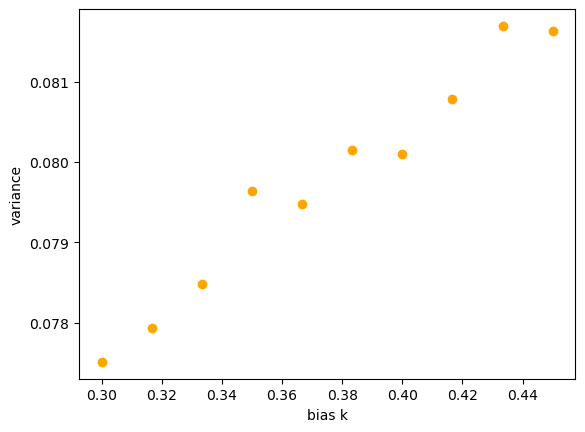

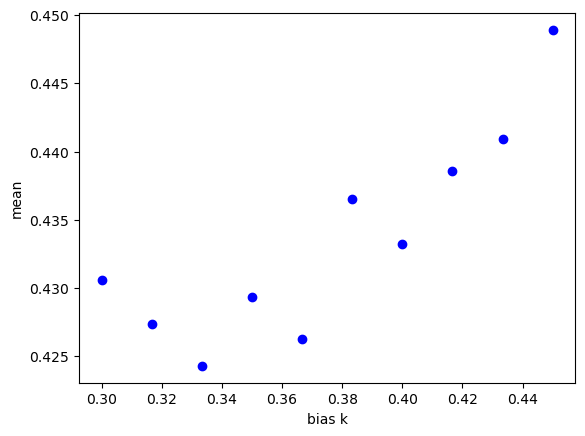

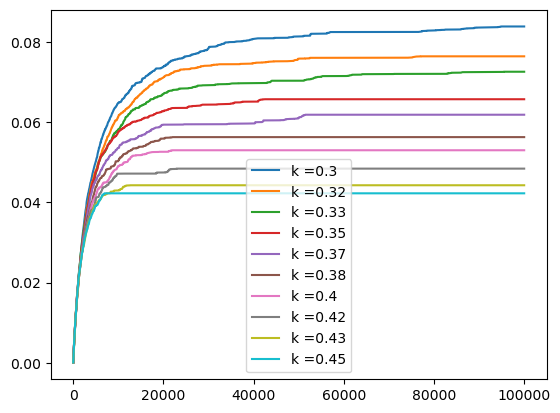

In [32]:
plt.scatter(bias_list, variance_list, color= 'orange')
plt.xlabel('bias k')
plt.ylabel('variance')
plt.show()

plt.scatter(bias_list, means_list, color = 'blue')
plt.xlabel('bias k')
plt.ylabel('mean')
plt.show()

# example = grids[0].threshold[:, 1]
# print(example)
# print(np.append())
# print(np.concat(example, []))
# print(np.concat(grids[0].threshold[:, 1], grids)

for indx ,grid in enumerate(grids):
    bias = 'k =' + str(round(bias_list[indx],2))
    plt.plot(grid.threshold[:, 0], grid.threshold[:, 1], label = bias)
plt.legend()
plt.show()



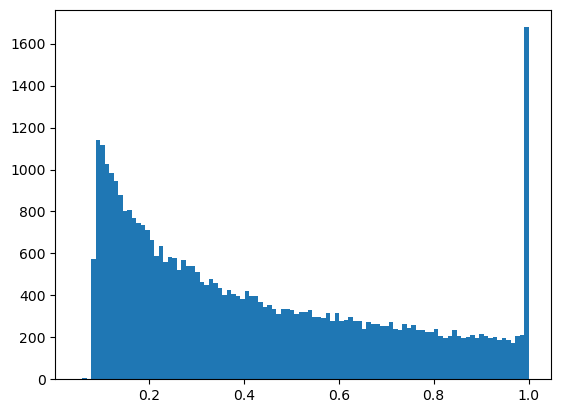

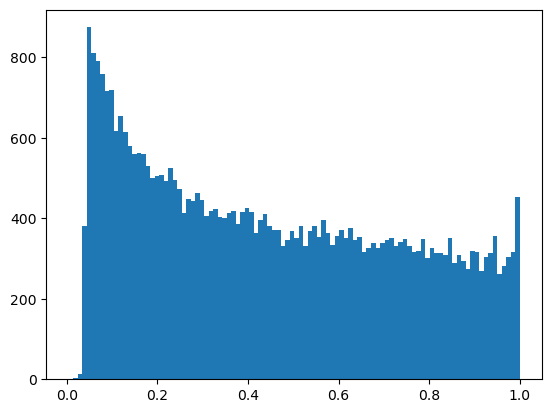

In [33]:
plt.hist(grids[0].current.flatten(), bins= 100)
plt.show()
plt.hist(grids[-1].current.flatten(), bins= 100)
plt.show()

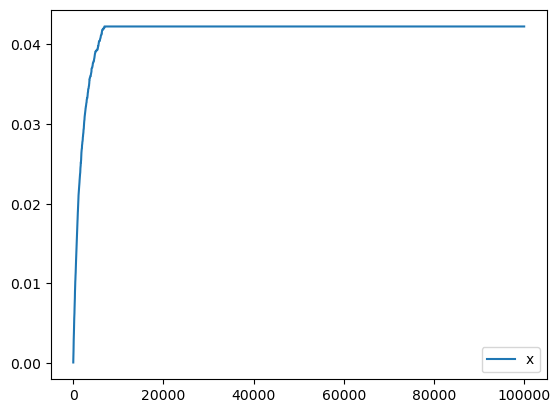

In [34]:
def plot_minima_and_threshold(grid, name='x'):
    s1 = np.arange(len(grid.minima))
#     plt.scatter(s1, grid.minima, s=0.1)
#     print(grid.threshold)
    s2, threshold = grid.threshold[:, 0], grid.threshold[:, 1]
    plt.plot(s2, threshold, label = name)
    plt.legend()
    return s2, threshold

def plot_threshold(grid):
    plt.plot(grid.threshold[:, 0], grid.threshold[:, 1])

s2, threshold = plot_minima_and_threshold(grid)

### Avalanche size frequency distribution

m is -1.9860135849154108
b is 7.260739903058279


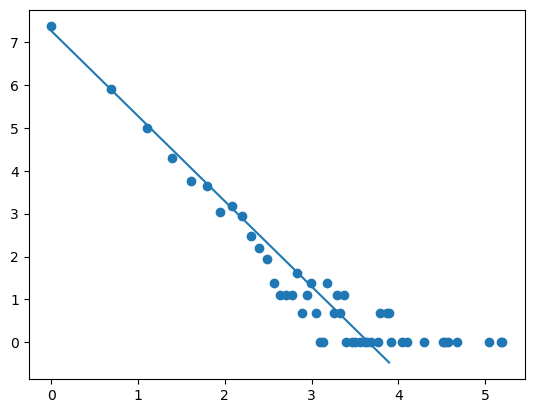

In [35]:
def fit_power_law(data):
    '''Fits the power law using '''
    # Define the power law function
    
    def power_law(x, m, b):
        return m*x+ b
    
    filtered_ones_log = data
    filtered_ones_log = data[data[:, 1] > 0]
    
    logx = filtered_ones_log[:,0]
    logy = filtered_ones_log[:,1]

    
    initial_guess = [2, logy[0]]
    bounds = [(-5,5), (logy[0]-0.5, logy[0]+0.5)]
    
    lower_bounds = [-np.inf,logy[0]-0.1]
    upper_bounds = [np.inf,logy[0]+0.1]
    
    params, covariance = curve_fit(power_law, logx, logy, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
#     params, covariance = curve_fit(power_law, logx, logy)
    # Fit the power law function to the data

    # Get the fitted parameters
    a_fit, b_fit = params
    print(f"m is {a_fit}")
    print(f"b is {b_fit}")

    # Generate fitted curve
    x_fit = np.linspace(logx[0], logx[-1], 10)
    
    y_fit = a_fit*x_fit+(b_fit)

    return x_fit, y_fit , a_fit, b_fit


frequencies = grid.avalanche_frequencies()

log_frequencies = np.log(frequencies)
x, y, m, b  = fit_power_law(log_frequencies)
plt.scatter(log_frequencies[:,0], log_frequencies[:,1])
plt.plot(x, y)

    

## Running for different grid sizes

<class '__main__.SimulationGrid'>
0
50
1
100
2
200


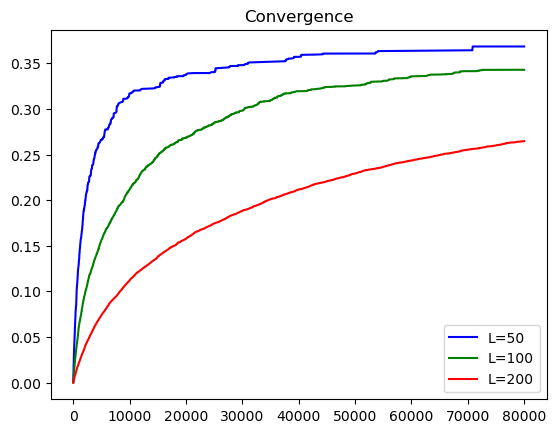

In [36]:
simulations_list = []

for L in [50,100,200]:
    grid = SimulationGrid(L)
    grid.run_iterations(80000, save=False)
    simulations_list.append(grid)
    
print(type(simulations_list[0]))
# colors = ['r','g', 'b', 'o']
colors = ['blue', 'green', 'red']


for indx, grid in enumerate(simulations_list):
    print(indx)
    print(grid.size)
    name = f"L={grid.size}"
    plt.plot(grid.threshold[:, 0], grid.threshold[:, 1], color= colors[indx], label=name)

plt.title('Convergence')
plt.legend()    
plt.show()


    


### Plotting frequencies

m is -1.8836027479697846
b is 4.217488115975877
m is -2.031226870962541
b is 5.752202479774476
m is -2.207841249561233
b is 7.034093741774924


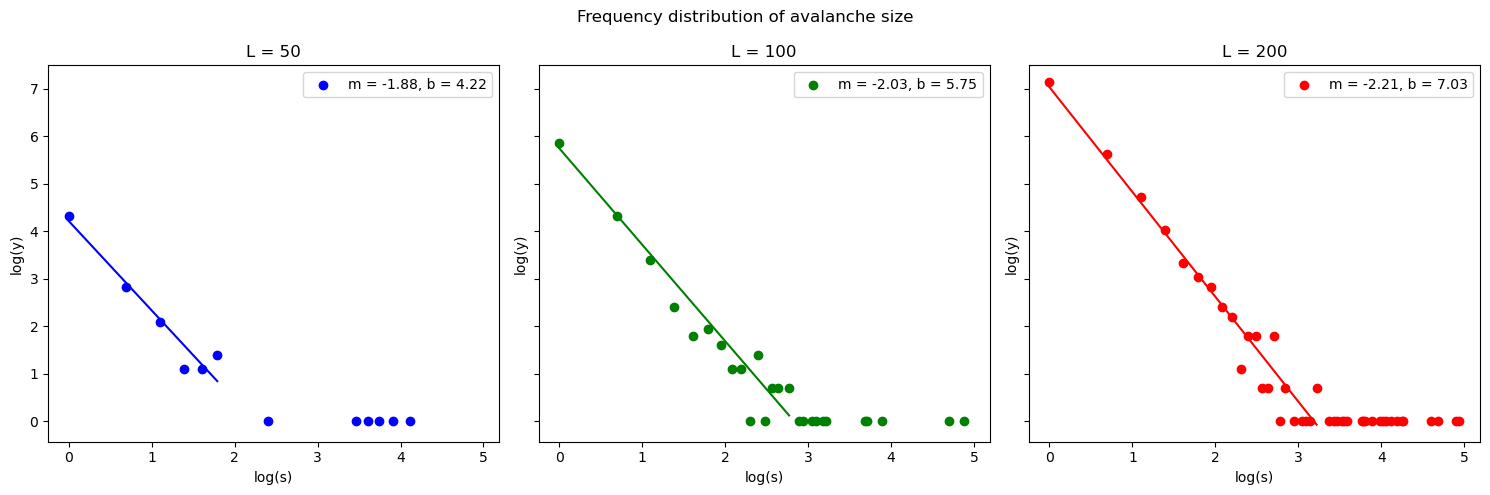

In [9]:
fig, axes = plt.subplots(1, len(simulations_list), sharey=True, sharex=True, figsize=(15, 5))

for indx, (grid, ax) in enumerate(zip(simulations_list, axes)):
    frequencies = grid.avalanche_frequencies()
    log_frequencies = np.log(frequencies)
    x, y , m ,b= fit_power_law(log_frequencies)
    name = f"m = {round(m,2)}, b = {round(b,2)}"
    ysum= np.sum(y)
    colors = ['blue', 'green', 'red']
    
    ax.scatter(log_frequencies[:, 0], log_frequencies[:, 1], color=colors[indx], label=name)
    ax.plot(x, y, color=colors[indx])

    ax.set_xlabel('log(s)')
    ax.set_ylabel('log(y)')
    ax.set_title(f'L = {grid.size}')
    ax.legend()
    # Set x-axis limits
#     ax.set_xlim(-0.2, 8)
plt.suptitle('Frequency distribution of avalanche size')

# Add legend to the last subplot
axes[-1].legend()

plt.tight_layout()
plt.show()

### Histogram distribution of fitness values

(array([ 99., 109., 101., 114.,  94., 104.,  87., 109., 100.,  83.]),
 array([3.94849185e-04, 1.00172224e-01, 1.99949599e-01, 2.99726973e-01,
        3.99504348e-01, 4.99281722e-01, 5.99059097e-01, 6.98836472e-01,
        7.98613846e-01, 8.98391221e-01, 9.98168596e-01]),
 <BarContainer object of 10 artists>)

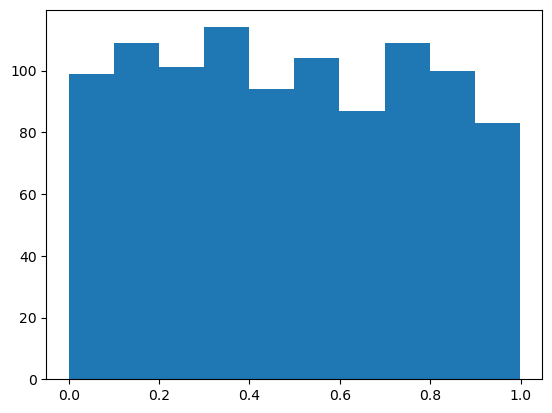

In [82]:
plt.hist([np.random.rand() for k in range(1000)])
    

# Testing convergence under different lambdas